In [2]:

import os
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [3]:

_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
path_to_downloaded_file = tf.keras.utils.get_file(
    "flower_photos",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True)
data_root=pathlib.Path(path_to_downloaded_file)


In [4]:
image_count=len(list(data_root.glob('*/*.jpg')))
print(image_count)

3670


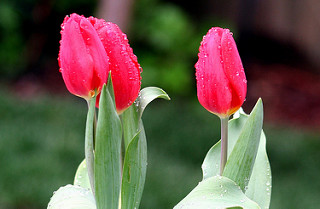

In [5]:
roses = list(data_root.glob('roses/*'))

PIL.Image.open((roses[0]))
PIL.Image.open(roses[1])

tulips=list(data_root.glob('tulips/*'))
PIL.Image.open(tulips[0])

CREATING A DATASET

In [12]:
BATCH_SIZE=32
IMAGE_HEIGHT=180
IMAGE_WIDTH=180

In [13]:
train_ds= tf.keras.utils.image_dataset_from_directory(data_root, validation_split=0.2, subset="training", seed=123, image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [14]:
val_ds= tf.keras.utils.image_dataset_from_directory(data_root, validation_split=0.2, subset="validation", seed=123, image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
class_names= train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


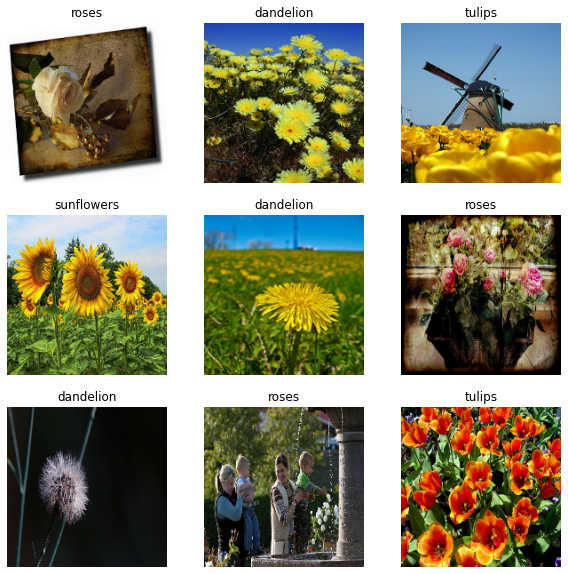

In [16]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        print(labels[i])



In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

print(train_ds)
print(type(train_ds))


(32, 180, 180, 3)
(32,)
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [18]:
AUTOTUNE= tf.data.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)
val_ds= val_ds.cache().prefetch(buffer_size=AUTOTUNE)

STANDARDIZING THE DATA- normalizing pixel values    

In [19]:
normalization_layer=layers.Rescaling(1./255)


In [20]:

normalized_ds= train_ds.map(lambda x, y:(normalization_layer(x), y))
image_batch, labels_batch=next(iter(normalized_ds))
first_image= image_batch[0]
print(first_image)
print(np.min(first_image), np.max(first_image))


tf.Tensor(
[[[0.21187365 0.22047931 0.3334423 ]
  [0.4901961  0.59084976 0.62418306]
  [0.84695    0.9138345  0.8528323 ]
  ...
  [0.7602397  0.6745098  0.45098042]
  [0.7558824  0.67254907 0.45326802]
  [0.7569718  0.6744009  0.4588236 ]]

 [[0.32320264 0.3777778  0.46862748]
  [0.6833334  0.78823537 0.78333336]
  [0.9258171  0.97810465 0.9362746 ]
  ...
  [0.7643791  0.6732027  0.45130724]
  [0.76274514 0.67549026 0.454902  ]
  [0.76437914 0.6794119  0.46013078]]

 [[0.49444452 0.60315907 0.6555556 ]
  [0.82908505 0.9218955  0.8869282 ]
  [0.9534859  0.9830066  0.9603486 ]
  ...
  [0.76851857 0.67080617 0.44836605]
  [0.7696079  0.67352945 0.45326802]
  [0.7745099  0.67843145 0.45817   ]]

 ...

 [[0.74967325 0.6830066  0.479085  ]
  [0.754902   0.68823534 0.48431376]
  [0.76285404 0.6961874  0.4922658 ]
  ...
  [0.7757081  0.6802833  0.4172114 ]
  [0.77352947 0.68823534 0.4258171 ]
  [0.76917213 0.69291943 0.43006545]]

 [[0.74967325 0.6830066  0.479085  ]
  [0.754902   0.68823534 0

TIME TO CREATE THE MODEL

In [21]:
num_classes=len(class_names)

model= Sequential([layers.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
                  layers.Conv2D(16, 3, padding='same', activation='relu' ),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Flatten(),
                  layers.Dense(128, activation='relu'),
                  layers.Dense(num_classes)
                  ])

COMPILE THE MODEL

In [22]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [24]:
epochs=10
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 85s 912ms/step - loss: 1.2557 - accuracy: 0.4656 - val_loss: 0.9779 - val_accuracy: 0.6022
Epoch 2/10
92/92 [==============================] - 91s 990ms/step - loss: 0.9115 - accuracy: 0.6328 - val_loss: 0.8809 - val_accuracy: 0.6471
Epoch 3/10
92/92 [==============================] - 80s 869ms/step - loss: 0.7392 - accuracy: 0.7163 - val_loss: 0.8158 - val_accuracy: 0.6839
Epoch 4/10
92/92 [==============================] - 74s 810ms/step - loss: 0.5587 - accuracy: 0.7994 - val_loss: 0.8621 - val_accuracy: 0.6553
Epoch 5/10
92/92 [==============================] - 78s 848ms/step - loss: 0.3497 - accuracy: 0.8777 - val_loss: 0.9141 - val_accuracy: 0.6798
Epoch 6/10
92/92 [==============================] - 78s 855ms/step - loss: 0.1847 - accuracy: 0.9384 - val_loss: 1.1376 - val_accuracy: 0.6744
Epoch 7/10
92/92 [==============================] - 70s 765ms/step - loss: 0.1538 - accuracy: 0.9520 - val_loss: 1.0937 - val_accuracy: 0.6689

VISUALIZE TRAINING RESULTS

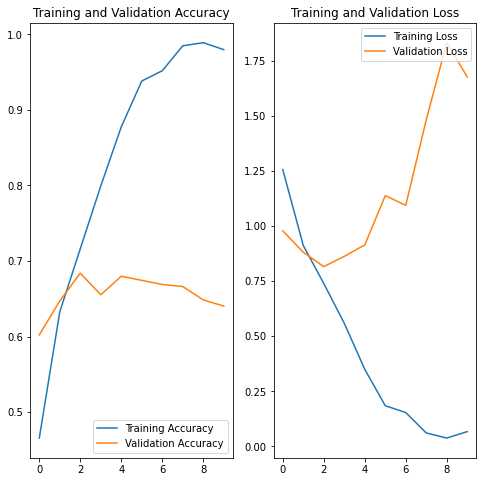

In [25]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

epochs_range=range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label= "Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training Loss")
plt.plot(epochs_range, val_loss, label= "Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

plt.show()


AUGMENTING THE DATA

In [26]:
data_augmentation= keras.Sequential([layers.RandomFlip("horizontal", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)), 
                                      layers.RandomRotation(0.1), layers.RandomZoom(0.1) ])

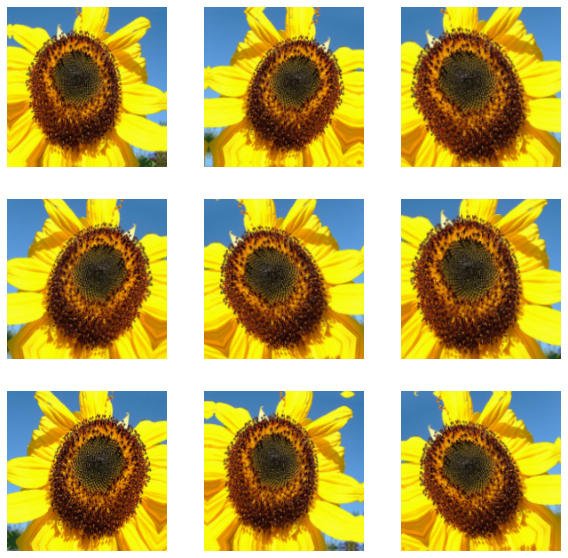

In [30]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images=data_augmentation(images)
        ax=plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


DROPOUT

In [31]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 50s 531ms/step - loss: 1.2371 - accuracy: 0.4608 - val_loss: 1.1230 - val_accuracy: 0.5572
Epoch 2/15
92/92 [==============================] - 50s 546ms/step - loss: 0.9931 - accuracy: 0.6073 - val_loss: 1.0426 - val_accuracy: 0.5777
Epoch 3/15
92/92 [==============================] - 52s 567ms/step - loss: 0.9001 - accuracy: 0.6482 - val_loss: 0.8805 - val_accuracy: 0.6567
Epoch 4/15
92/92 [==============================] - 53s 578ms/step - loss: 0.8271 - accuracy: 0.6812 - val_loss: 0.8813 - val_accuracy: 0.6567
Epoch 5/15
92/92 [==============================] - 796s 9s/step - loss: 0.7949 - accuracy: 0.6931 - val_loss: 0.8229 - val_accuracy: 0.6948
Epoch 6/15
92/92 [==============================] - 52s 570ms/step - loss: 0.7281 - accuracy: 0.7200 - val_loss: 0.8594 - val_accuracy: 0.6744
Epoch 7/15
92/92 [==============================] - 57s 621ms/step - loss: 0.7053 - accuracy: 0.7405 - val_loss: 0.7811 - val_accuracy: 0.6798
E

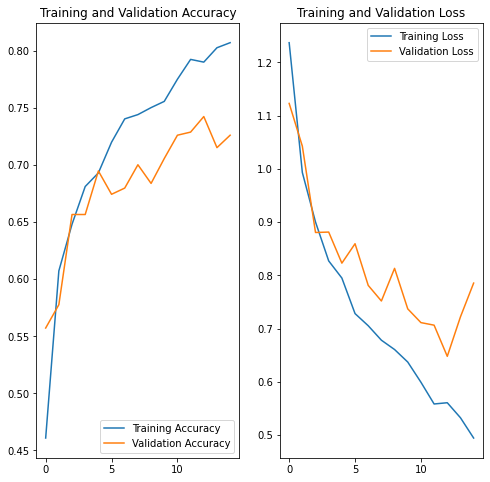

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [41]:


image_one_url="https://img1.cgtrader.com/items/2361389/1a52aa3afb/large/dandelion-3d-model-animated-max-obj-fbx.jpg"
image_one_path= tf.keras.utils.get_file('1', origin=image_one_url)


img = tf.keras.utils.load_img(
   image_one_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

40960/26150 [==============================================] - 0s 6us/step
This image most likely belongs to dandelion with a 48.79 percent confidence.
